In [73]:
import praw
import sqlite3

conn = sqlite3.connect('reddit.db')
c = conn.cursor()

c.execute('''DROP TABLE IF EXISTS topics''')
c.execute('''DROP TABLE IF EXISTS comments''')

c.execute('''CREATE TABLE topics (topicTitle text, topicText text, topicID text, topicCategory text)''')
c.execute('''CREATE TABLE comments (commentText text, commentID text, topicTitle text, topicText text, topicID text, topicCategory text)''')

user_agent = "Introduceing Data Science Book"
r = praw.Reddit(user_agent=user_agent, client_id = '4D2A7pe9rUVauw', client_secret = 'fzm6SEcsjh9DJN3_vzmKTtnaBPM')

subreddits = ['datascience', 'gameofthrones']

limit = 1000



In [74]:
def prawGetData(limit, subredditName):
    topics = r.subreddit(subredditName).hot(limit = limit)
    print(f'processing {subredditName}')
    commentInsert = []
    topicInsert = []
    topicNBR = 1
    for topic in topics:
        if (topicNBR % 100==0):
            print(f'topic no {topicNBR}')
        topicNBR += 1
        try:
            topicInsert.append((topic.title, topic.selftext, topic.id, subredditName))
        except Exception as e:
            print(e)
            pass
        try:
            for comment in topic.comments:
                commentInsert.append((comment.body, comment.id, topic.title, topic.selftext, topic.id, subredditName))
        except Exception as e:
            print(e)
            pass
    
    # print(topicInsert)
    # print(commentInsert)

    print ('inserting data into sql lite')

    c.executemany('INSERT INTO topics VALUES (?,?,?,?)', topicInsert)
    c.executemany('INSERT INTO comments VALUES (?,?,?,?,?,?)', commentInsert)

    conn.commit()


In [75]:
c = conn.cursor()
c.execute('SELECT * FROM topics')
x = c.fetchone()
print(x)

None


In [76]:
for subject in subreddits:
    prawGetData(limit = limit, subredditName=subject)

processing datascience
topic no 100
topic no 200
topic no 300
topic no 400
topic no 500
topic no 600
inserting data into sql lite
processing gameofthrones
topic no 100
topic no 200
topic no 300
topic no 400
topic no 500
inserting data into sql lite


# Data preparation

In [77]:
import nltk
import matplotlib.pyplot as plt
from collections import OrderedDict
import random

nltk.download('punkt')
nltk.download('stopwords')
#conn = sqlite3.connect('reddit.db')
#c = conn.cursor()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\E10112538\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\E10112538\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [78]:
def wordFilter(excluded, wordrow):
    filtered = [word for word in wordrow if word not in excluded]
    return filtered

stopwords = nltk.corpus.stopwords.words('english')

def lowerCaseArray(wordrow):
    lowercased = [word.lower() for word in wordrow]
    return lowercased

In [79]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [107]:
stemmer = nltk.SnowballStemmer("english")

def wordStemmer(wordrow):
    stemmed = [stemmer.stem(word) for word in wordrow]
    return stemmed

# manual list takes almost every single character on the keyboard
manual_stopwords = [',','.',')',',','(','m',"'m","n't",'e.g',"'ve",'s','#','/','``',"'s","''",'!','r',']','=','[','s','&','%','*','...','1','2','3','4','5','6','7','8','9','10','--',"''",';','-',':']

In [109]:


def data_processing(sql,manual_stopwords):
    c.execute(sql) #1
    data = {'wordMatrix':[],'all_words':[]}
    interWordMatrix = []
    interWordList = []
    row = c.fetchone() #2
    while row is not None:
        tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+') #3 
        wordrow = tokenizer.tokenize(row[0]+" "+row[1])       
        wordrow_lowercased = lowerCaseArray(wordrow)
        wordrow_nostopwords = wordFilter(stopwords,wordrow_lowercased)
        wordrow_nostopwords = wordFilter(manual_stopwords,wordrow_nostopwords)#4
        wordrow_stemmed = wordStemmer(wordrow_nostopwords)
        interWordList.extend(wordrow_stemmed)#5
        interWordMatrix.append(wordrow_stemmed)#6
        row = c.fetchone()#7
        
    wordfreqs = nltk.FreqDist(interWordList)#8
    hapaxes = wordfreqs.hapaxes()#9
    for wordvector in interWordMatrix:
        wordvector_nohapexes = wordFilter(hapaxes,wordvector) #10
        data['wordMatrix'].append(wordvector_nohapexes)
        data['all_words'].extend(wordvector_nohapexes)
        
    return data
#1 create pointer to the sqlite data
#2 fetch the data one by one
#3 row[0] is the title, row[1] is the topic text, we turn them into a single text blob
#4 remove manual stopword
#5 temporary wordlist used to remove hapaxes later on
#6 temporary wordmatrix, will become final wordmatrix after hapaxes removal
#7 get a new topic
#8 make a frequency distribution of all terms
#9 get the list of hapaxes
#10 remove the hapaxes

subreddits = ['datascience','gameofthrones']
data = {}
for subject in subreddits:
    data[subject] = data_processing(sql=f"SELECT topicTitle, topicText, topicCategory FROM topics WHERE topicCategory = '{subject}'", manual_stopwords=manual_stopwords)

In [93]:
print (data['datascience']['wordMatrix'][0])

['weekly', 'entering', '&', 'transitioning', 'thread', '|', '26', 'jul', '2020', '-', '02', 'aug', '2020', 'welcome', 'week', "'s", 'entering', '&', 'transitioning', 'thread', '!', 'thread', 'questions', 'getting', 'started', ',', 'studying', ',', 'transitioning', 'data', 'science', 'field', '.', 'topics', 'include', ':', '*', 'learning', 'resources', '(', 'e.g', '.', 'books', ',', 'tutorials', ',', 'videos', ')', '*', 'traditional', 'education', '(', 'e.g', '.', 'schools', ',', 'degrees', ',', 'electives', ')', '*', 'alternative', 'education', '(', 'e.g', '.', 'online', 'courses', ',', 'bootcamps', ')', '*', 'job', 'search', 'questions', '(', 'e.g', '.', 'resumes', ',', 'applying', ',', 'career', 'prospects', ')', '*', 'elementary', 'questions', '(', 'e.g', '.', 'start', ',', 'next', ')', 'wait', 'answers', 'community', ',', 'check', '[', 'faq', ']', '(', 'https', ':', '//www.reddit.com/r/datascience/wiki/frequently-asked-questions', ')', '[', 'resources', ']', '(', 'resources', ')', 

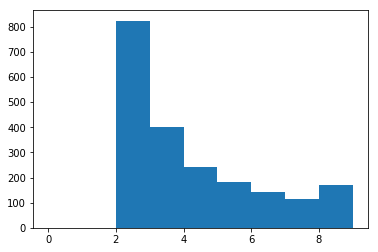

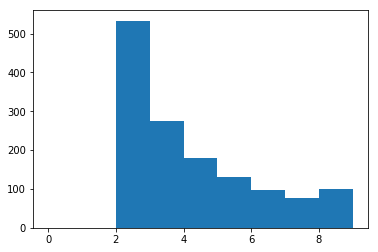

In [110]:
wordfreqs_cat1 = nltk.FreqDist(data['datascience']['all_words'])
plt.hist(wordfreqs_cat1.values(), bins = range(10))
plt.show()
wordfreqs_cat2 = nltk.FreqDist(data['gameofthrones']['all_words'])
plt.hist(wordfreqs_cat2.values(), bins = range(10))
plt.show()

In [111]:
print (wordfreqs_cat1.hapaxes())
print (wordfreqs_cat2.hapaxes())

[]
[]


In [112]:
print (wordfreqs_cat1.most_common(20))
print (wordfreqs_cat2.most_common(20))

[('data', 1459), ('work', 596), ('use', 555), ('scienc', 457), ('like', 423), ('would', 362), ('model', 343), ('learn', 318), ('get', 305), ('time', 294), ('compani', 288), ('job', 273), ('know', 242), ('scientist', 240), ('want', 230), ('project', 211), ('question', 207), ('one', 205), ('look', 203), ('need', 191)]
[('spoiler', 569), ('season', 234), ('show', 188), ('king', 186), ('jon', 179), ('would', 169), ('throne', 169), ('like', 147), ('think', 142), ('one', 134), ('game', 130), ('watch', 129), ('got', 120), ('end', 111), ('time', 109), ('poll', 100), ('episod', 92), ('dragon', 91), ('know', 91), ('book', 90)]


In [105]:
print wordfreqs_cat1.hapaxes()
print wordfreqs_cat2.hapaxes()

SyntaxError: invalid syntax (<ipython-input-105-ac9d904a1e5e>, line 1)

In [104]:
print (wordfreqs_cat1.hapaxes())
print (wordfreqs_cat2.hapaxes())

, 'matched', '200', 'rag', 'tag', 'criminals', 'thorne', 'blend', 'egret', 'brave', 'pips', 'cursed', 'among', 'wallet', 'keeper', 'jons', 'sending', 'nightswatch', 'bloodline', 'militarized', '*every*', 'switch', 'non-combatants', 'rigid', 'structure', 'square', 'applies', 'participates', 'ladies', 'trade', 'armored', 'opposed', 'ornate', 'multi-colored', 'dresses/jewels', 'ditched', 'regal', 'greek', 'goddess-like', 'gowns', 'alternates', 'space-age', 'fur', 'lined', 'queenly', 'moved', 'locations', 'climates', 'require', 'lighter', 'bulk', 'furs', 'tyene', 'craster', 'happily', 'blessed', '//preview.redd.it/r8a1gfxu07b51.png', 'width=2880', 's=98821ba7ec50cda7537517727bb7524e7760cb6f', '//preview.redd.it/hoq2espw07b51.jpg', 'width=1920', 's=72c2a73a2afc6dbc63bd9d1345a67c63c05539c8', 'shiny', 'era', 'nominally', 'scar', 'long-term', 'governance', 'deposed', 'exile', 'decades', 'underprivileged', 'amass', 'devotees', 'shortly', 'thereafter', 'abuse', 'depicted', 'recognise', 'fave', '

In [122]:
holdoutLength  = 100
#labeled data
labeled_data1 = [(word,'datascience') for word in data['datascience']['wordMatrix'][holdoutLength:]]
labeled_data2 = [(word,'gameofthrones') for word in data['gameofthrones']['wordMatrix'][holdoutLength:]]
labeled_data = []
labeled_data.extend(labeled_data1)
labeled_data.extend(labeled_data2)
#create holdout
holdout_data = data['datascience']['wordMatrix'][:holdoutLength]
holdout_data.extend(data['gameofthrones']['wordMatrix'][:holdoutLength])
holdout_data_labels = ([('datascience') for _ in range(holdoutLength)] + [('gameofthrones') for _ in range(holdoutLength)])

In [125]:
print (len(labeled_data))
print (len(holdout_data_labels))
print (labeled_data[20])

978
200
(['much', 'data', 'scienc', 'work', 'look', 'solut', 'work', 'peopl', 'internet', 'im', 'newbi', 'learn', 'data', 'scienc', 'sinc', 'broad', 'field', 'wonder', 'much', 'data', 'scienc', 'profession', 'look', 'solut', 'anoth', 'peopl', 'work'], 'datascience')


In [127]:
data['datascience']['all_words_dedup'] = list(OrderedDict.fromkeys(data['datascience']['all_words']))
data['gameofthrones']['all_words_dedup'] = list(OrderedDict.fromkeys(data['gameofthrones']['all_words']))

In [128]:
all_words = []
all_words.extend(data['datascience']['all_words_dedup'])
all_words.extend(data['gameofthrones']['all_words_dedup'])

In [129]:
all_words_dedup = list(OrderedDict.fromkeys(all_words))

In [130]:
prepared_data = [({word: (word in x[0]) for word in all_words_dedup}, x[1]) for x in labeled_data]
prepared_holdout_data = [({word: (word in x[0]) for word in all_words_dedup}) for x in holdout_data]

In [132]:
print (prepared_data[0])

 'funni': False, 'crap': False, 'entic': False, 'slower': False, 'xkcd': False, 'subsid': False, 'refactor': False, 'seaborn': False, 'brought': False, 'void': False, 'undoubt': False, 'rabbit': False, 'hole': False, 'conceptu': False, 'deepli': False, 'bold': False, 'casino': False, 'gender': False, 'tempt': False, 'meta': False, 'machinelearn': False, 'buzzword': False, 'cooler': False, 'regardless': False, 'overrun': False, 'overflow': False, 'homework': False, 'effort': False, 'bot': False, 'flair': False, 'revisit': False, 'dabbl': False, 'anticip': False, 'acquisit': False, 'median': False, 'rental': False, 'yoy': False, 'rent': False, 'composit': False, 'nosql': False, 'skew': False, 'skim': False, 'white': False, 'card': False, 'cap': False, 'status': False, 'queu': False, 'hackernew': False, 'lobster': False, 'fluff': False, 'corona': False, 'desk': False, 'reput': False, 'multi': False, 'erd': False, 'export': False, 'autocomplet': False, 'psql': False, 'pgcli': False, 'ipyth

In [133]:
random.shuffle(prepared_data)
train_size = int(len(prepared_data) * 0.75)
train = prepared_data[:train_size]
test = prepared_data[train_size:]

In [135]:
nbr_got = 0
nbr_data = 0
for set in train:
    if set[1]=='datascience':
        nbr_data+=1
    if set[1]=='gameofthrones':
        nbr_got+=1
print (nbr_got)
print (nbr_data)

342
391


In [137]:
classifier  = nltk.NaiveBayesClassifier.train(train)

In [138]:
nltk.classify.accuracy(classifier, test)

0.9673469387755103

In [141]:
classifier2 = nltk.DecisionTreeClassifier.train(train)

In [142]:
nltk.classify.accuracy(classifier2, test)


1.0